<a href="https://colab.research.google.com/github/jairorodriguezarias/matching_engine_create_multimodal_embeddings/blob/main/vector_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:


# Install the packages
! pip3 install --upgrade google-cloud-aiplatform \
                         google-cloud-storage

! pip install google-cloud-vision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 28.3 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.17.3
    Uninstalling google-auth-2.17.3:
      Successfully uninstalled google-auth-2.17.3
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.8.0
    Uninstalling google-cloud-storage-2.8.0:
      Successfully uninstalled google-cloud-storage-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 5.3 MB/s eta 0:00:00


In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

# Configuration


In [3]:
from google.colab import auth
auth.authenticate_user()

In [165]:
PROJECT_ID = "genai-387907"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [164]:
REGION = "us-central1"  # @param {type: "string"}

Cloud Storage

In [162]:
BUCKET_NAME = "vector_store"

In [163]:
BUCKET_URI = f"gs://{BUCKET_NAME}-{PROJECT_ID}-unique"  # @param {type:"string"}

In [8]:
# Only if your bucket doesn't exist
# ! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

In [35]:
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://vector_store-genai-387907-images/* ./images

Copying gs://vector_store-genai-387907-images/0000000112_2_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0077307081_6_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0085454807_1_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0264474302_1_1_1.jpg...
| [4 files][  1.9 MiB/  1.9 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://vector_store-genai-387907-images/0310009999_1_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0310274999_6_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0387157052_1_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0475691990_6_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0478630300_1_1_1.jpg...
Copying gs://vector_store-genai-38790

In [139]:
image_directory = "/content"

# Cloud Vision Embeddings

In [140]:
import os

In [141]:
import glob
image_names = glob.glob('images/*.jpg')

In [142]:
# image_directory = "/content/images"
# image_names = ['0478630300_1_1_1.jpg', '0485561712_6_1_1.jpg', '1165680701_1_1_1.jpg']

image_paths = [os.path.join(image_directory, image_name) for image_name in image_names]

print(image_paths)

['/content/images/4786289251_1_1_1.jpg', '/content/images/0077307081_6_1_1.jpg', '/content/images/2308012712_1_1_1.jpg', '/content/images/5372302070_6_1_1.jpg', '/content/images/0387157052_1_1_1.jpg', '/content/images/6164179427_1_1_1.jpg', '/content/images/5536562712_6_1_1.jpg', '/content/images/0518059711_1_1_1.jpg', '/content/images/4174838670_1_1_1.jpg', '/content/images/2823305500_6_1_1.jpg', '/content/images/2460220800_6_1_1.jpg', '/content/images/4174813250_1_1_1.jpg', '/content/images/8686244485_1_1_1.jpg', '/content/images/6061548959_6_1_1.jpg', '/content/images/3897152080_1_1_1.jpg', '/content/images/3991101712_1_1_1.jpg', '/content/images/1856360808_1_1_1.jpg', '/content/images/5070503800_6_1_1.jpg', '/content/images/3918601717_6_1_1.jpg', '/content/images/0000000112_2_1_1.jpg', '/content/images/6224396251_6_1_1.jpg', '/content/images/8563717403_1_1_1.jpg', '/content/images/1165680701_1_1_1.jpg', '/content/images/3336237611_6_1_1.jpg', '/content/images/5070646800_1_1_1.jpg',

Perform rate-limited explicit image detection

In [143]:
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Optional

import numpy as np
from tqdm import tqdm

# Create a rate limiter with a limit of 1800 requests per minute
seconds_per_job = 1 / (1800 / 60)


def process_image(image_path: str) -> Optional[bool]:
    try:
        annotation = detect_safe_search(image_path)

        if annotation:
            return convert_annotation_to_safety(safe_search_annotation=annotation)
        else:
            return None
    except Exception:
        return None


# Process images using ThreadPool
is_safe_values_cloud_vision = []
with ThreadPoolExecutor() as executor:
    futures = []
    for img_url in tqdm(image_paths, total=len(image_paths), position=0):
        futures.append(executor.submit(process_image, img_url))
        time.sleep(seconds_per_job)

    for future in futures:
        is_safe_values_cloud_vision.append(future.result())

# Set Nones to False
is_safe_values_cloud_vision = [
    is_safe or False for is_safe in is_safe_values_cloud_vision
]

# Print number of safe images found
print(
    f"Safe images = {np.array(is_safe_values_cloud_vision).sum()} out of {len(is_safe_values_cloud_vision)} images"
)

100%|██████████| 117/117 [00:04<00:00, 28.95it/s]

Safe images = 0 out of 117 images


Defining encoding functions


In [144]:
import base64
import time
import typing

from google.cloud import aiplatform
from google.protobuf import struct_pb2


class EmbeddingResponse(typing.NamedTuple):
    text_embedding: typing.Sequence[float]
    image_embedding: typing.Sequence[float]


def load_image_bytes(image_uri: str) -> bytes:
    """Load image bytes from a remote or local URI."""
    image_bytes = None
    if image_uri.startswith("http://") or image_uri.startswith("https://"):
        response = requests.get(image_uri, stream=True)
        if response.status_code == 200:
            image_bytes = response.content
    else:
        image_bytes = open(image_uri, "rb").read()
    return image_bytes


class EmbeddingPredictionClient:
    """Wrapper around Prediction Service Client."""

    def __init__(
        self,
        project: str,
        location: str = "us-central1",
        api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com",
    ):
        client_options = {"api_endpoint": api_regional_endpoint}
        # Initialize client that will be used to create and send requests.
        # This client only needs to be created once, and can be reused for multiple requests.
        self.client = aiplatform.gapic.PredictionServiceClient(
            client_options=client_options
        )
        self.location = location
        self.project = project

    def get_embedding(self, text: str = None, image_file: str = None):
        if not text and not image_file:
            raise ValueError("At least one of text or image_file must be specified.")

        # Load image file
        image_bytes = None
        if image_file:
            image_bytes = load_image_bytes(image_file)

        instance = struct_pb2.Struct()
        if text:
            instance.fields["text"].string_value = text

        if image_bytes:
            encoded_content = base64.b64encode(image_bytes).decode("utf-8")
            image_struct = instance.fields["image"].struct_value
            image_struct.fields["bytesBase64Encoded"].string_value = encoded_content

        instances = [instance]
        endpoint = (
            f"projects/{self.project}/locations/{self.location}"
            "/publishers/google/models/multimodalembedding@001"
        )
        response = self.client.predict(endpoint=endpoint, instances=instances)

        text_embedding = None
        if text:
            text_emb_value = response.predictions[0]["textEmbedding"]
            text_embedding = [v for v in text_emb_value]

        image_embedding = None
        if image_bytes:
            image_emb_value = response.predictions[0]["imageEmbedding"]
            image_embedding = [v for v in image_emb_value]

        return EmbeddingResponse(
            text_embedding=text_embedding, image_embedding=image_embedding
        )

Create helper functions to process data in batches

In [145]:
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Callable, Generator, List

from tqdm.auto import tqdm


def generate_batches(
    inputs: List[str], batch_size: int
) -> Generator[List[str], None, None]:
    """
    Generator function that takes a list of strings and a batch size, and yields batches of the specified size.
    """

    for i in range(0, len(inputs), batch_size):
        yield inputs[i : i + batch_size]


API_IMAGES_PER_SECOND = 2


def encode_to_embeddings_chunked(
    process_function: Callable[[List[str]], List[Optional[List[float]]]],
    items: List[str],
    batch_size: int = 1,
) -> List[Optional[List[float]]]:
    """
    Function that encodes a list of strings into embeddings using a process function.
    It takes a list of strings and returns a list of optional lists of floats.
    The data is processed in chunks to prevent out-of-memory errors.
    """

    embeddings_list: List[Optional[List[float]]] = []

    # Prepare the batches using a generator
    batches = generate_batches(items, batch_size)

    seconds_per_job = batch_size / API_IMAGES_PER_SECOND

    with ThreadPoolExecutor() as executor:
        futures = []
        for batch in tqdm(batches, total=len(items) // batch_size, position=0):
            futures.append(executor.submit(process_function, batch))
            time.sleep(seconds_per_job)

        for future in futures:
            embeddings_list.extend(future.result())
    return embeddings_list


Create functions that wrap embedding functions in try-except and retry logic.

In [146]:
import copy
from typing import List, Optional

import numpy as np
import requests
from tenacity import retry, stop_after_attempt

client = EmbeddingPredictionClient(project=PROJECT_ID)


# Use a retry handler in case of failure
@retry(reraise=True, stop=stop_after_attempt(3))
def encode_texts_to_embeddings_with_retry(text: List[str]) -> List[List[float]]:
    assert len(text) == 1

    try:
        return [client.get_embedding(text=text[0], image_file=None).text_embedding]
    except Exception:
        raise RuntimeError("Error getting embedding.")


def encode_texts_to_embeddings(text: List[str]) -> List[Optional[List[float]]]:
    try:
        return encode_texts_to_embeddings_with_retry(text=text)
    except Exception:
        return [None for _ in range(len(text))]


@retry(reraise=True, stop=stop_after_attempt(3))
def encode_images_to_embeddings_with_retry(image_uris: List[str]) -> List[List[float]]:
    assert len(image_uris) == 1

    try:
        return [
            client.get_embedding(text=None, image_file=image_uris[0]).image_embedding
        ]
    except Exception as ex:
        print(ex)
        raise RuntimeError("Error getting embedding.")


def encode_images_to_embeddings(image_uris: List[str]) -> List[Optional[List[float]]]:
    try:
        return encode_images_to_embeddings_with_retry(image_uris=image_uris)
    except Exception as ex:
        print(ex)
        return [None for _ in range(len(image_uris))]


Test the encoding function

In [147]:
%%time
# Encode a sample subset of images
image_paths_filtered = list(image_paths)[:1000]
image_embeddings = encode_to_embeddings_chunked(
    process_function=encode_images_to_embeddings, items=image_paths_filtered
)

# Keep only non-None embeddings
indexes_to_keep, image_embeddings = zip(
    *[
        (index, embedding)
        for index, embedding in enumerate(image_embeddings)
        if embedding is not None
    ]
)

print(f"Processed {len(indexes_to_keep)} embeddings successfully")


  0%|          | 0/117 [00:00<?, ?it/s]

400 Image embedding failed with the following error: Image size must be smaller than 20971520 bytes.
400 Image embedding failed with the following error: Image size must be smaller than 20971520 bytes.
400 Image embedding failed with the following error: Image size must be smaller than 20971520 bytes.
Error getting embedding.
Processed 116 embeddings successfully
CPU times: user 2.2 s, sys: 240 ms, total: 2.44 s
Wall time: 1min 1s


In [148]:
import numpy as np


def dot_product_distance(
    text_embedding: np.ndarray, image_embeddings: np.ndarray
) -> np.ndarray:
    """Compute dot-product distance between text and image embeddings by taking the dot product"""
    return np.dot(text_embedding, image_embeddings.T)


<class 'list'>
<class 'float'>
<class 'tuple'>
<class 'list'>


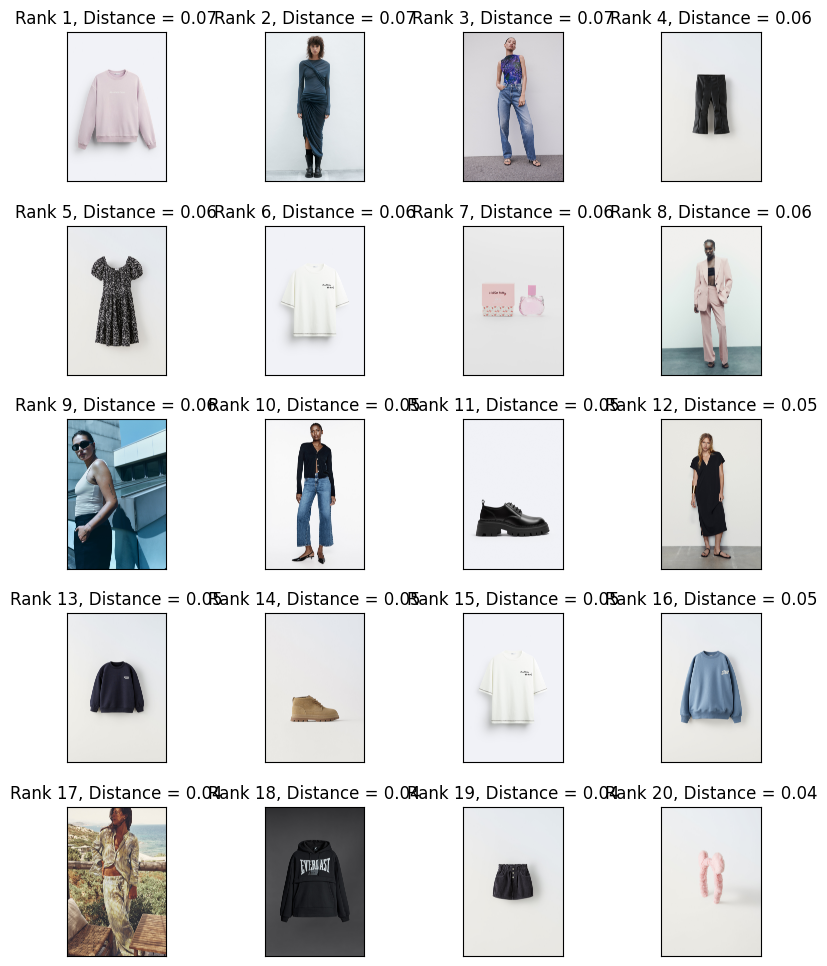

In [149]:
import math
from io import BytesIO

import matplotlib.pyplot as plt
from PIL import Image

text_query = "jacket blue"

# Calculate text embedding of query
text_embedding = encode_texts_to_embeddings(text=[text_query])[0]

print(type(text_embedding))
print(type(text_embedding[0]))

print(type(image_embeddings))
print(type(image_embeddings[0]))

# Calculate distance
distances = dot_product_distance(
    text_embedding=np.array(text_embedding), image_embeddings=np.array(image_embeddings)
)

# Set the maximum number of images to display
MAX_IMAGES = 20

# Sort images and scores by descending order of scores and select the top max_images
sorted_data = sorted(
    zip(image_paths_filtered, distances), key=lambda x: x[1], reverse=True
)[:MAX_IMAGES]

# Calculate the number of rows and columns needed to display the images
num_cols = 4
num_rows = math.ceil(len(sorted_data) / num_cols)


# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, (image_path, distance) in enumerate(sorted_data):
    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Check if image_path is a remote URL
    if image_path.startswith("http://") or image_path.startswith("https://"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)

    # Display the image in the current subplot
    axs[row_idx, col_idx].imshow(image, cmap="gray")

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Rank {i+1}, Distance = {distance:.2f}")

    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

In [158]:
DIMENSIONS = len(text_embedding)

print(DIMENSIONS)

1408


Save the embedding in JSONL formt

In [ ]:
import tempfile

# Create temporary file to write embeddings to
embeddings_file = tempfile.NamedTemporaryFile(suffix=".json", delete=False)

embeddings_file.name

In [160]:
import json
import random

BATCH_SIZE = 1000


mylist = ["even", "odd"]


with open(embeddings_file.name, "a") as f:
    for i in tqdm(range(0, len(image_names), BATCH_SIZE)):
        image_names_chunk = image_names[i : i + BATCH_SIZE]
        image_paths_chunk = image_paths[i : i + BATCH_SIZE]

        embeddings = encode_to_embeddings_chunked(
            process_function=encode_images_to_embeddings, items=image_paths_chunk
        )

        # Append to file
        embeddings_formatted = [
            json.dumps(
                {
                    "id": str(id),
                    "embedding": [str(value) for value in embedding],
                    "restricts": [
                        {
                           "namespace": "class",
                           "allow_list": ["even" if id % 2 == 0 else "odd"],
                       }
                ],
            }
        )
            + "\n"
            for id, embedding in zip(image_names_chunk, embeddings)
            if embedding is not None
        ]
        print(embeddings_formatted)
        f.writelines(embeddings_formatted)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

400 Image embedding failed with the following error: Image size must be smaller than 20971520 bytes.
400 Image embedding failed with the following error: Image size must be smaller than 20971520 bytes.
400 Image embedding failed with the following error: Image size must be smaller than 20971520 bytes.
Error getting embedding.


TypeError: ignored

In [167]:
import json
import random

BATCH_SIZE = 1000


mylist = ["even", "odd"]


with open(embeddings_file.name, "a") as f:
    for i in tqdm(range(0, len(image_names), BATCH_SIZE)):
        image_names_chunk = image_names[i : i + BATCH_SIZE]
        image_paths_chunk = image_paths[i : i + BATCH_SIZE]

        embeddings = encode_to_embeddings_chunked(
            process_function=encode_images_to_embeddings, items=image_paths_chunk
        )

        # Append to file
        embeddings_formatted = [
            json.dumps(
                {
                    "id": str(id),
                    "embedding": [str(value) for value in embedding],
            }
        )
            + "\n"
            for id, embedding in zip(image_names_chunk, embeddings)
            if embedding is not None
        ]
        print(embeddings_formatted)
        f.writelines(embeddings_formatted)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

400 Image embedding failed with the following error: Image size must be smaller than 20971520 bytes.
400 Image embedding failed with the following error: Image size must be smaller than 20971520 bytes.
400 Image embedding failed with the following error: Image size must be smaller than 20971520 bytes.
Error getting embedding.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Upload the training data to Cloud Storage

In [168]:
UNIQUE_FOLDER_NAME = "embeddings_folder_unique"
EMBEDDINGS_INITIAL_URI = f"{BUCKET_URI}/{UNIQUE_FOLDER_NAME}/"
! gsutil cp {embeddings_file.name} {EMBEDDINGS_INITIAL_URI}

Copying file:///tmp/tmpn_udy29u.json [Content-Type=application/json]...
|
Operation completed over 1 objects/2.6 MiB.                                      


# **Create INDEX. ANN**

In [169]:
DIMENSIONS = 100.   ####. ESTO ESTA MAL, las dimensiones de entrada deben ser
DIMENSIONS = len(text_embedding)
DISPLAY_NAME = "multimodal_images"
DESCRIPTION = "Multimodal Images Embeddings"

In [170]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

Create the index configuration

In [ ]:
tree_ah_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name=DISPLAY_NAME,
    contents_delta_uri=EMBEDDINGS_INITIAL_URI,
    dimensions=DIMENSIONS,
    approximate_neighbors_count=10,
    distance_measure_type="COSINE_DISTANCE",
    # distance_measure_type="DOT_PRODUCT_DISTANCE",
    # distance_measure_type="SQUARED_L2_DISTANCE",
    leaf_node_embedding_count=10,
    leaf_nodes_to_search_percent=7,
    description="Image Index",
    labels={"label_name": "label_value"},
)

INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:Creating MatchingEngineIndex
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:Create MatchingEngineIndex backing LRO: projects/899604603048/locations/us-central1/indexes/48981043994165248/operations/2277388129323188224


In [ ]:
INDEX_RESOURCE_NAME = tree_ah_index.resource_name
INDEX_RESOURCE_NAME

Name

In [ ]:
tree_ah_index = aiplatform.MatchingEngineIndex(index_name=INDEX_RESOURCE_NAME)

## Create an IndexEndpoint

In [ ]:
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=DISPLAY_NAME,
    description=DISPLAY_NAME,
    public_endpoint_enabled=True,
)

# Deploy Indexes

In [ ]:
DEPLOYED_INDEX_ID = "deployed_index_id_unique"

DEPLOYED_INDEX_ID

In [ ]:
my_index_endpoint = my_index_endpoint.deploy_index(
    index=tree_ah_index, deployed_index_id=DEPLOYED_INDEX_ID
)

my_index_endpoint.deployed_indexes

Verify number of items

In [ ]:
number_of_vectors = sum(
    aiplatform.MatchingEngineIndex(
        deployed_index.index
    )._gca_resource.index_stats.vectors_count
    for deployed_index in my_index_endpoint.deployed_indexes
)

print(f"Expected: {BQ_NUM_ROWS}, Actual: {number_of_vectors}")

## Create Online Queries

In [ ]:
test_embeddings = encode_texts_to_embeddings(sentences=["jacket blue"])

In [ ]:
# Test query
NUM_NEIGHBOURS = 10

response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=test_embeddings,
    num_neighbors=NUM_NEIGHBOURS,
    filter=[Namespace("class", ["even"])],
)

response